In [1]:
# Change the directory form the notebook
%cd ..

/Users/Espenel/Desktop/Mini-Grant-Image-analysis/2018/Humsa/HumsaTraces


# Humsa project - Calcium release / Synchronicity

In [2]:
# load all the necessary modules for the analysis
from cellsync.io import *
from cellsync.registration import *
from cellsync.segmentation import *
from cellsync.correlation import *
from cellsync.plot_traces import *
from cellsync.synchronicity import *
from cellsync.to_dataframe import *
from cellsync.metadata import *

In [3]:
# Ignore warnings in notebook
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Plot inside the notebook
%matplotlib inline
# this is used for debugging purposes only. allows to reload classes when changed
%load_ext autoreload
%autoreload 2

In [5]:
import matplotlib.pyplot as plt

In [6]:
# General parameters of the plot
plt.rcParams['figure.figsize'] = 8,8
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Opening the file

In [7]:
%cd ..

/Users/Espenel/Desktop/Mini-Grant-Image-analysis/2018/Humsa


In [8]:
# Define the data directory

path_File = 'TSeries-04032018-1326-slicenewpatch-035_nbqx122_ap5200_to_analayze/'
#path_File = 'TSeries-06262018-1323estim1-electroderad-001'
#path_File = 'TSeries-04032018-036_to_analyze'
#path_File = "CBX_inhibitor_analysis/0327_CBX"
#path_File = "CBX_inhibitor_analysis/0416_CBX"
#path_File = "CBX_inhibitor_analysis/0503_CBX"
#path_File = "DIPG6/DIPG6_0719_spont_007"
#path_File = "DIPG6/DIPG6_0719_estim_008"
#path_File = "Etrectrinib/081018_001"

In [9]:
# The function metadata will generate a Python dictionaty with some important information
meta = metadata(path_File)

In [10]:
for key in meta:
    print(key)

sizeT
sizeX
sizeY
dtype
shapeX
shapeY
TimePoint


In [11]:
# open_file will open the file as a numpy stack.
# File should be in subfolder/_channel_1 or 

ch1 = open_file(path_File, meta, ch="/channel_1")
ch2 = open_file(path_File, meta, ch="/channel_2")

In [12]:
#ch1 = io.imread(path_File+"/"+"channel_1.tif")

# Introduction to Numpy

In Python, images are represented as `numpy` arrays. A single-channel, or grayscale, image is a 2D matrix of pixel intensities of shape `(row, column)`. We can construct a 3D volume as a series of 2D `planes`, giving 3D images the shape `(plane, row, column)`. Multichannel data adds a `channel` dimension in the final position containing color information. 

These conventions are summarized in the table below:


|Image type|Coordinates|
|:---|:---|
|2D grayscale|(row, column)|
|2D multichannel|(row, column, channel)|
|3D grayscale|(plane, row, column)|
|3D multichannel|(plane, row, column, channel)|

Note that, although, some 3D images are constructed with equal resolution in each dimension. In microscopy, data captured in the Z dimension have (usually) lower resolution than in XY. The distance between pixels in each dimension, called `spacing`, is encoded in a tuple and is accepted as a parameter by some `skimage` functions and can be used to adjust contributions to filters.


In [13]:
print("ch1 shape:", ch1.shape)
print("type:", ch1.dtype)
print("Size in bytes:", ch1.nbytes)

ch1 shape: (3000, 322, 366)
type: uint16
Size in bytes: 707112000


We need to make sure that the data have the write shape:

In [14]:
if len(ch1)%10!=0:
    to_analyse_max = len(ch1) - len(ch1)%100
else:
    to_analyse_max = len(ch1)

We can also directly choose the part of the data we would like to analyse:

In [15]:
to_analyse_min =  0
#to_analyse_max = 1900

In [16]:
#It is possible to select only the first 1000 frames:
ch1 = ch1[to_analyse_min:to_analyse_max]
ch2 = ch2[to_analyse_min:to_analyse_max]
#However, it's important to adjust the metadata
meta['TimePoint'] = meta['TimePoint'][to_analyse_min:to_analyse_max]
meta['sizeT'] = len(meta['TimePoint'])

In [17]:
print("ch1 shape:", ch1.shape)
print("type:", ch1.dtype)
print("Size in bytes:", ch1.nbytes)

ch1 shape: (3000, 322, 366)
type: uint16
Size in bytes: 707112000


# Visualization of the data

In [18]:
from ipywidgets import interact, fixed
import ipywidgets as widgets

In [19]:
@interact(img = fixed(ch1[0]), x=(0,len(ch1)-1), continuous_update=False)
def widget(x):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharex=True, sharey=True)
    ax.imshow(ch1[x,::2,::2])
    plt.show()

interactive(children=(IntSlider(value=1499, description='x', max=2999), Output()), _dom_classes=('widget-inter…

# Motion correction
First we create a motion correction object (shift) by using phase correlation to identify the relative shift between two similar-sized images.

In [20]:
shifts = list_shift(ch1)

We can plot the result:

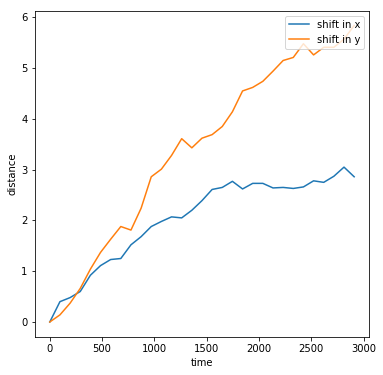

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharex=True, sharey=True)
x_range = np.arange(0, ch1.shape[0], np.ceil(ch1.shape[0]/len(shifts)))
ax.plot(x_range, shifts[:,0], label='shift in x')
ax.plot(x_range, shifts[:,1], label='shift in y')
ax.legend(loc='upper right')
ax.set_ylabel('distance')
ax.set_xlabel('time')

### Using the measured shift, we can now perform motion correction.

In [22]:
reg_ch1 = registration(ch1, shifts)

Cell bellow can be use to inspect in detail the result

Alternatively we can "visually" inspect the result

In [24]:
@interact(img = fixed(reg_ch1[0]), x=(0,len(ch1)-1), continuous_update=False)
def widget(x):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharex=True, sharey=True)
    ax.imshow(reg_ch1[x,::2,::2])
    plt.show()

interactive(children=(IntSlider(value=1499, description='x', max=2999), Output()), _dom_classes=('widget-inter…

# Segmentation using SLIC (Simple Linear Iterative Clustering), a K-Means based image segmentation.
[Achanta et al. 2012](https://ieeexplore.ieee.org/document/6205760/)

### The arg "strength" may need to be adjusted (usually between 50 and 300) between experiment if data are over or under segmented

In [25]:
strength=100

In [26]:
seg, im_reg = slic_segment(reg_ch1, strength=strength)

Visualyse the segmentation result:

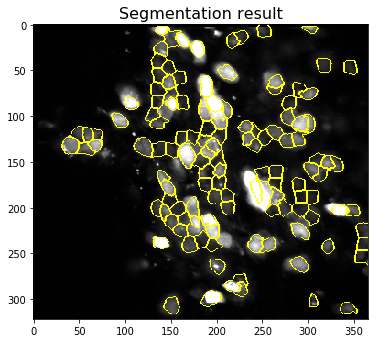

In [27]:
from skimage import exposure, segmentation
p2, p98 = np.percentile(im_reg.astype(np.int16), (2, 98))
new_eq = exposure.rescale_intensity(im_reg.astype(np.int16), in_range=(p2, p98))
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(segmentation.mark_boundaries(new_eq, seg))
ax.set_title('Segmentation result', fontsize=16)

### Registration channel2 (Ca) using the registration object calculated on ch1

In [28]:
ch2_reg = registration(ch2, shifts)

# Create correlation image
The correlation image for each pixel is computed by averaging the correlation coefficients (taken over time) of each pixel with its four immediate neighbors. Based on [Pnevmatikakis et al. 2016](https://www.cell.com/neuron/abstract/S0896-62731501084-3)

In [29]:
ch2_corr = correlations(ch2_reg)

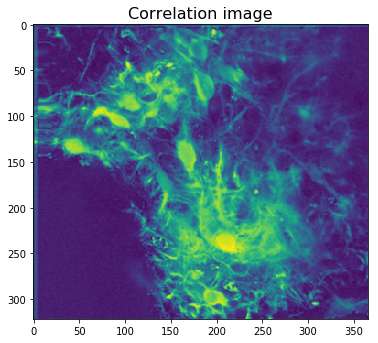

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(ch2_corr)
ax.set_title('Correlation image', fontsize=16)

# Extract ${\Delta F}/F$ fluorescence trace
Based on [Pnevmatikakis et al. 2016](https://www.cell.com/neuron/abstract/S0896-62731501084-3):
${\Delta F}/F$ value at frame i of ROI j-th is computed by subtracting its mean intensity with the 20th percentile of the previous `window_deltaF` (~size of the peak) frames and dividing it by the same number. 

In [31]:
window_deltaF = 20
to_remove = None

In [32]:
d, data, cell_position, labels, regions_ch2,seg = create_traces(ch2_reg,seg, window = window_deltaF, to_remove=to_remove)

# Plot traces
If save=True, data will be save, you cam add an argument path='xx' to enter the directory to where you want to save the result. Plot would be save as 'plot_traces'

In [33]:
tp_min =  0
tp_max = len(data)-1
#tp_max=100

In [34]:
filename_roi = '_ROI_'+str(tp_min)+'_'+str(tp_max)

In [35]:
path = path_File
save = True
if save:
    import time
    folder_name = path+'/'+'result'+filename_roi+'_'+time.strftime("%Y%m%d-%H%M")
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    path = folder_name

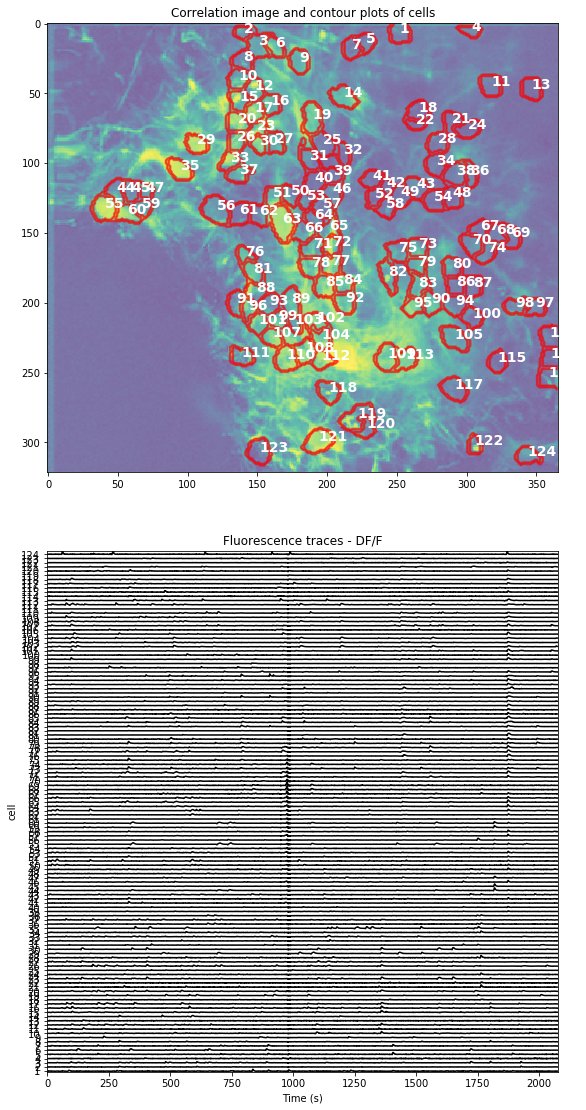

In [36]:
plot_traces(ch2_corr, meta, data, seg, cell_position, labels,
                plot_all = False, ymin=None, ymax=None, tmin=meta["TimePoint"][tp_min], 
            tmax=meta["TimePoint"][tp_max], save=save, path=path, filename_roi = filename_roi)

# Find synchronization and plot
Data are first smooth and then local maxima of calcium signals were detected by the [detect_peaks](http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb) function writtend by Marcos Duarte. The spike is then extracted by finding the beginning of the slope.

The synchronicity S, which was defined by [Osswald et al. 2015](https://www.nature.com/articles/nature16071) as
the fraction of the whole number of synchronous cells (NSyn) divided by the number of calcium peaks for the given cell (NCa). In case the cells were not active, a synchronicity of zero was allotted. 
If save=True, data will be save, you cam add an argument path='xx' to enter the directory to where you want to save the result. Plot would be save as 'plot_correlation'

In [37]:
sync_time=4
print("time frame =",  meta["TimePoint"][sync_time]- meta["TimePoint"][0], "sec")

time frame = 2.8 sec


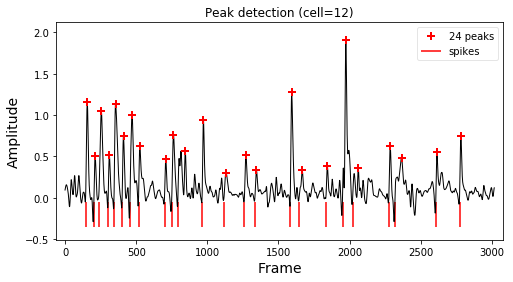

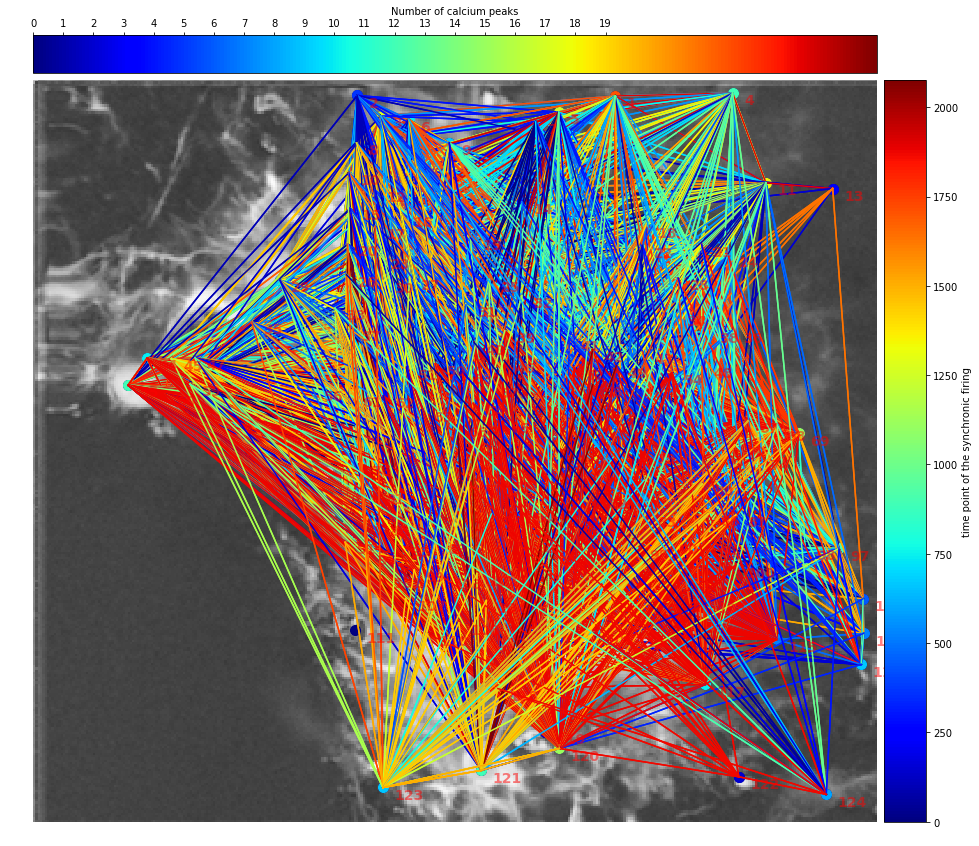

In [38]:
# sync_time is the window used around each peak to calculate synchronicity.
# Using sea_peak, you can sea the result of the detect_peak function on specific traces.

indexes, sync, peak_value = find_sync(d, meta, ch2_corr, regions_ch2, 
                            labels, cell_position, sync_time=sync_time, 
                            show=True, sea_peak = 12, roi = True,
                            tmin = tp_min, tmax = tp_max, dmin = 1, dmax = None,
                            save=save, path=path,filename_roi=filename_roi)

# Convert data into a Pandas dataframe - Tabular data

If the argument save is equal to True, then the result will be save as an excel file. 

In [39]:
df, df1 = to_df(indexes,sync, peak_value,d, meta, save = save, path=path, filename_roi=filename_roi)

In [40]:
df.head()

,Nbr of Peaks,Nbr of Sync Cells,Peak Position,Peak Value,Sync cells,Synchronicity
1,23,73,"[8.3, 89.4, 285.4, 409.4, 534.1, 568.0, 613.0,...","[0.1, 0.41, 0.07, -0.01, 0.15, 0.04, 0.23, 0.2...","[3, 4, 5, 7, 8, 9, 10, 11, 12, 15, 16, 19, 21,...",3.17
2,5,39,"[98.4, 295.1, 482.1, 595.0, 1928.5]","[0.18, 0.32, -0.06, 0.12, 0.11]","[3, 5, 6, 7, 8, 10, 11, 12, 14, 19, 22, 26, 33...",7.80
3,17,84,"[42.3, 97.0, 126.1, 295.1, 338.7, 484.2, 568.0...","[0.04, 0.33, 0.31, 0.33, 0.24, 0.13, 0.14, 0.3...","[1, 2, 4, 5, 6, 7, 8, 10, 12, 14, 15, 16, 17, ...",4.94
4,12,58,"[153.1, 398.3, 566.6, 705.9, 746.7, 809.1, 958...","[0.17, 0.29, 0.11, 0.03, 0.41, 0.24, 0.36, 0.2...","[1, 3, 5, 7, 8, 10, 11, 12, 14, 15, 16, 17, 20...",4.83
5,17,68,"[20.8, 90.1, 207.8, 295.1, 502.2, 706.6, 794.5...","[0.13, 0.1, 0.24, 0.25, 0.07, -0.04, 0.11, 0.3...","[1, 2, 3, 4, 7, 8, 10, 11, 12, 14, 15, 16, 17,...",4.00


In [41]:
str(window_deltaF)

'20'

In [42]:
log = {'path':path, 
       'save':save, 
       'filename_roi':filename_roi, 
       'strength':strength, 
       'window_deltaF': window_deltaF,
       'to_remove': to_remove}

log_file(**log)